This run has higher dropout, larger size lstm.

This run has validation accuracy around 70%+

From results shown, high dropout does contribute to regularization. Compared to the first run, validation accuracy doesn't improve, however the training history is less oscillatory.

In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Activation, Flatten
from keras.utils import to_categorical
import numpy as np
import h5py
import matplotlib.pyplot as plt
from data_utils import get_data
from sklearn import preprocessing


/mnt/g/Course/2017-2018_4th_year/2018_winter/ECE_239AS/Project/.env4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data from all .mat files, combine them, eliminate EOG signals, shuffle and 
# seperate training data, validation data and testing data.
# Also do mean subtraction on x.

data = get_data('../project_datasets',num_validation=100, num_test=100, subtract_mean=True, subtract_axis=1,
                transpose=True)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (2358, 1000, 22) 
y_train: (2358,) 
X_val: (100, 1000, 22) 
y_val: (100,) 
X_test: (100, 1000, 22) 
y_test: (100,) 


In [3]:
num_classes = 4

# substract data from list
X_train = data.get('X_train')
y_train = data.get('y_train')
X_val = data.get('X_val')
y_val = data.get('y_val')
X_test = data.get('X_test')
y_test = data.get('y_test')

# get data dimension
N_train, T_train, C_train = data.get('X_train').shape
N_val, T_val, C_val = data.get('X_val').shape
N_test, T_test, C_test = data.get('X_test').shape

# add dummy zeros for y classification, convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [4]:
# construct X_total and y_total based on sub-sampling of X_train and y_train

# take sub-sampling on the time sequence to reduce dimension for RNN
sampling = 1

X_train = X_train.reshape(N_train,int(T_train/sampling), sampling, C_train)[:,:,0,:]
X_val = X_val.reshape(N_val,int(T_val/sampling), sampling, C_val)[:,:,0,:]
X_test = X_test.reshape(N_test,int(T_test/sampling), sampling, C_test)[:,:,0,:]

# get new data dimension
N_train, T_train, C_train = X_train.shape
N_val, T_val, C_val = X_val.shape
N_test, T_test, C_test = X_test.shape

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (2358, 1000, 22)
y_train:  (2358, 4)
X_val:  (100, 1000, 22)
y_val:  (100, 4)
X_test:  (100, 1000, 22)
y_test:  (100, 4)


In [5]:
# Expected input batch shape: (batch_size, timesteps, data_dim)
# Note that we have to provide the full batch_input_shape since the network is stateful.
# the sample of index i in batch k is the follow-up for the sample i in batch k-1.

# perhaps should try masking layer

data_dim = C_train
timesteps = T_train
batch_size = 100
num_epoch = 100

# make a sequential model
model = Sequential()

# add 1-layer cnn
model.add(Conv1D(40, kernel_size=12, strides=4,
          input_shape=(timesteps, data_dim)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4, strides=4))


# add 2-layer lstm
model.add(LSTM(30, return_sequences=True, stateful=False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(20, return_sequences=True, stateful=False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# set loss function and optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [6]:
# train the data with validation
history = model.fit(X_train, y_train,
                    batch_size=batch_size, 
                    epochs=num_epoch, 
                    shuffle=False,
                    validation_data=(X_val, y_val))

Train on 2358 samples, validate on 100 samples
Epoch 1/100
2358/2358 [==============================] - 6s 2ms/step - loss: 1.8368 - acc: 0.2829 - val_loss: 1.4178 - val_acc: 0.2900
Epoch 2/100
2358/2358 [==============================] - 4s 2ms/step - loss: 1.6181 - acc: 0.3210 - val_loss: 1.3884 - val_acc: 0.3300
Epoch 3/100
2358/2358 [==============================] - 4s 2ms/step - loss: 1.5852 - acc: 0.3308 - val_loss: 1.3302 - val_acc: 0.3500
Epoch 4/100
2358/2358 [==============================] - 4s 2ms/step - loss: 1.4907 - acc: 0.3584 - val_loss: 1.2796 - val_acc: 0.3800
Epoch 5/100
2358/2358 [==============================] - 4s 2ms/step - loss: 1.4308 - acc: 0.3762 - val_loss: 1.2361 - val_acc: 0.4700
Epoch 6/100
2358/2358 [==============================] - 4s 2ms/step - loss: 1.3928 - acc: 0.3991 - val_loss: 1.1804 - val_acc: 0.5800
Epoch 7/100
2358/2358 [==============================] - 4s 2ms/step - loss: 1.3531 - acc: 0.4084 - val_loss: 1.1677 - val_acc: 0.5200
Epoch 8/

Epoch 61/100
2358/2358 [==============================] - 5s 2ms/step - loss: 0.6101 - acc: 0.7583 - val_loss: 0.9924 - val_acc: 0.5900
Epoch 62/100
2358/2358 [==============================] - 4s 2ms/step - loss: 0.6245 - acc: 0.7515 - val_loss: 0.8705 - val_acc: 0.6500
Epoch 63/100
2358/2358 [==============================] - 4s 2ms/step - loss: 0.5959 - acc: 0.7710 - val_loss: 0.8827 - val_acc: 0.6400
Epoch 64/100
2358/2358 [==============================] - 5s 2ms/step - loss: 0.6057 - acc: 0.7646 - val_loss: 0.8352 - val_acc: 0.6500
Epoch 65/100
2358/2358 [==============================] - 5s 2ms/step - loss: 0.6172 - acc: 0.7684 - val_loss: 0.7862 - val_acc: 0.7100
Epoch 66/100
2358/2358 [==============================] - 5s 2ms/step - loss: 0.5887 - acc: 0.7735 - val_loss: 0.9267 - val_acc: 0.6300
Epoch 67/100
2358/2358 [==============================] - 5s 2ms/step - loss: 0.5760 - acc: 0.7676 - val_loss: 0.8292 - val_acc: 0.6700
Epoch 68/100
2358/2358 [========================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


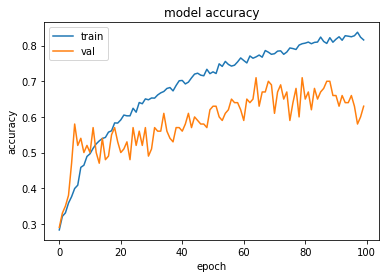

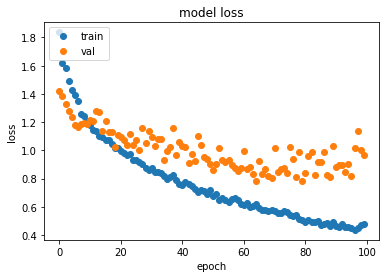

In [7]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
# test set
model.evaluate(X_test,y_test,batch_size=N_test)

100/100 [==============================] - 0s 502us/step


[0.8794256448745728, 0.6800000071525574]